In [1]:
# Import Packages and setup
import os
import logging
from astropy.table import Table as ApTable

import numpy as np

import scarlet
import scarlet.display

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')

In [2]:
idx = 8
#idx = 11
#idx = 13
#idx = 14
#idx = 20
#idx = 22
#idx = 27
#idx = 44
#idx = 48
datapath = '/Users/fred/lsst/code/testdata_deblender/real_data/hsc_cosmos/not_matched'
files = os.listdir(datapath)
data = np.load(os.path.join(datapath, files[idx]))
images = data["images"]
psfs = data["psfs"]
peaks = data["peaks"]
weights = data["weights"]

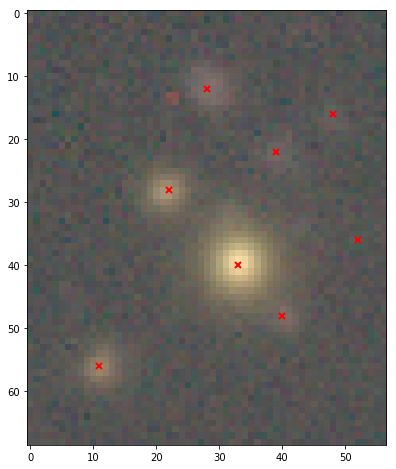

In [3]:
# Use Asinh scaling for the images
norm = []
for b in range(len(images)):
    vmin, vmax = scarlet.display.zscale(images[b], fraction=.5)
    if b==0:
        _vmin = vmin
    norm.append(scarlet.display.Asinh(img=images[b], Q=80, vmin=_vmin, vmax=vmax))

vmin, vmax = scarlet.display.zscale(images, fraction=.75)
norm = scarlet.display.Asinh(Q=80, vmin=vmin, vmax=vmax)
    
# Map i,r,g -> RGB
filter_indices = [3,2,1]
#filter_indices = [2,1,0]
# Convert the image to an RGB image
img_rgb = scarlet.display.img_to_rgb(images, filter_indices=filter_indices, norm=norm)
plt.figure(figsize=(8,8))
plt.imshow(img_rgb)
#peaks = np.vstack([peaks, [[20,19]]])
for peak in peaks:
    plt.plot(peak[0], peak[1], "rx", mew=2)
plt.show()

In [4]:
bg_rms = np.sqrt(np.std(images, axis=(1,2))**2 + np.median(images, axis=(1,2))**2)
print(np.std(images, axis=(1,2)))
print(np.median(images, axis=(1,2)))
bg_rms

[ 0.04821193  0.13800456  0.42254823  0.72387475  0.67858601]
[ 0.01054702  0.01337322  0.0293423   0.04966278  0.08303248]


array([ 0.0493521 ,  0.13865101,  0.4235658 ,  0.72557634,  0.6836471 ], dtype=float32)

In [6]:
sources = []
for n,peak in enumerate(peaks):
    try:
        result = scarlet.ExtendedSource((peak[1], peak[0]), images, bg_rms, psf=psfs)
        sources.append(result)
    except:
        print("No flux in peak {0} at {1}".format(n, peak))

blend_psf = scarlet.Blend(sources, images, bg_rms=bg_rms)
%time blend_psf.fit(100, e_rel=.015)
print("scarlet ran for {0} iterations".format(blend_psf.it))

No flux in peak 7 at [ 52.  36.]


CPU times: user 4.45 s, sys: 17.1 ms, total: 4.47 s
Wall time: 4.46 s
scarlet ran for 100 iterations


Data range: -0.5036830306053162 to 15.331342697143555
residual range: -1.037308333433769 to 2.593440240727867
rms: 0.10520104540882033


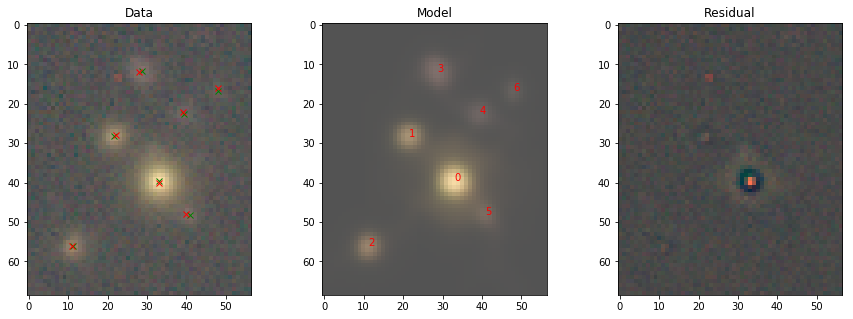

In [7]:
# Load the model and calculate the residual
model = blend_psf.get_model()
residual = images-model
print("Data range: {0} to {1}\nresidual range: {2} to {3}\nrms: {4}".format(
    np.min(images),
    np.max(images),
    np.min(residual),
    np.max(residual),
    np.sqrt(np.std(residual)**2+np.mean(residual)**2)
))
# Create RGB images
model_rgb = scarlet.display.img_to_rgb(model, filter_indices=filter_indices, norm=norm)
residual_norm = scarlet.display.Linear(img=residual)
residual_rgb = scarlet.display.img_to_rgb(residual, filter_indices=filter_indices, norm=residual_norm)

# Show the data, model, and residual
fig = plt.figure(figsize=(15,5))
ax = [fig.add_subplot(1,3,n+1) for n in range(3)]
ax[0].imshow(img_rgb)
ax[0].set_title("Data")
ax[1].imshow(model_rgb)
ax[1].set_title("Model")
ax[2].imshow(residual_rgb)
ax[2].set_title("Residual")
for m in range(len(blend_psf.sources)):
    y,x = blend_psf.sources[m].center
    px, py = peaks[m]
    ax[0].plot(x, y, "gx")
    ax[0].plot(px, py, "rx")
    ax[1].text(x, y, m, color="r")
plt.show()

In [8]:
sources = []
for n,peak in enumerate(peaks):
    try:
        result = scarlet.ExtendedSource((peak[1], peak[0]), images, bg_rms)
        sources.append(result)
    except:
        print("No flux in peak {0} at {1}".format(n, peak))
blend = scarlet.Blend(sources, images, bg_rms=bg_rms)
%time blend.fit(100, e_rel=.015)
print(blend.it)

No flux in peak 7 at [ 52.  36.]
CPU times: user 454 ms, sys: 9.22 ms, total: 463 ms
Wall time: 456 ms
88


Data range: -0.5036830306053162 to 15.331342697143555
residual range: -2.358328976113258 to 2.0437302910481936
rms: 0.10989652194918383


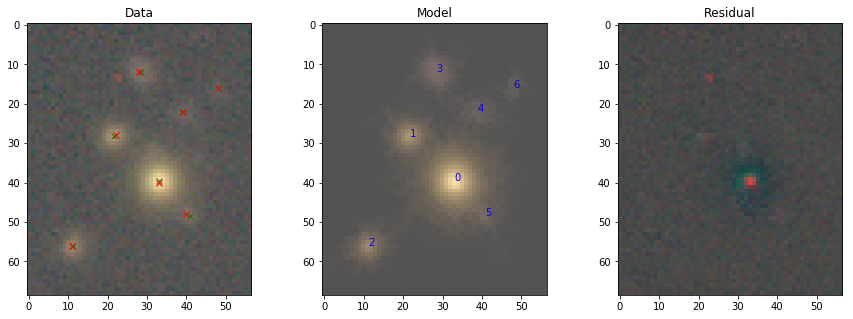

In [9]:
# Load the model and calculate the residual
model = blend.get_model()
residual = images-model
print("Data range: {0} to {1}\nresidual range: {2} to {3}\nrms: {4}".format(
    np.min(images),
    np.max(images),
    np.min(residual),
    np.max(residual),
    np.sqrt(np.std(residual)**2+np.mean(residual)**2)
))

# Create RGB images
model_rgb = scarlet.display.img_to_rgb(model, filter_indices=filter_indices, norm=norm)
residual_rgb = scarlet.display.img_to_rgb(residual, filter_indices=filter_indices, norm=residual_norm)

# Show the data, model, and residual
fig = plt.figure(figsize=(15,5))
ax = [fig.add_subplot(1,3,n+1) for n in range(3)]
ax[0].imshow(img_rgb)
ax[0].set_title("Data")
ax[1].imshow(model_rgb)
ax[1].set_title("Model")
ax[2].imshow(residual_rgb)
ax[2].set_title("Residual")
for m in range(len(blend.sources)):
    y,x = blend.sources[m].center
    px, py = peaks[m]
    ax[0].plot(x, y, "gx")
    ax[0].plot(px, py, "rx")
    ax[1].text(x, y, m, color="b")
plt.show()

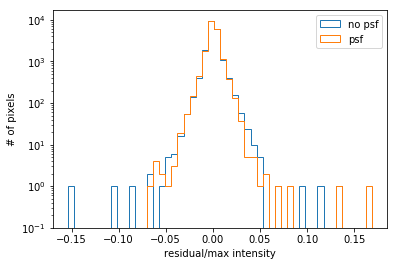

In [10]:
model_psf = blend_psf.get_model()
model = blend.get_model()
residual_psf = (images-model_psf)/np.max(images)
residual = (images-model)/np.max(images)
hist_range = np.min([residual_psf, residual]), np.max([residual_psf, residual])
plt.hist(residual.reshape(-1), range=hist_range, bins=50, histtype='step', label="no psf", log=True)
plt.hist(residual_psf.reshape(-1), range=hist_range, bins=50, histtype='step', label="psf")
plt.legend()
plt.xlabel("residual/max intensity")
plt.ylabel("# of pixels")
plt.show()

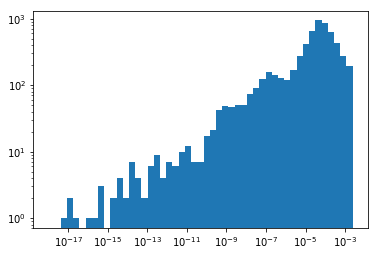

In [11]:
plt.xscale('log')
plt.hist(psfs.reshape(-1), bins=10**np.linspace(-18, np.log(np.max(psfs)), 50), log=True)
plt.show()

In [12]:
cutoff = 1e-4
prox_monotonic = scarlet.operators.prox_strict_monotonic(psfs[0].shape, use_nearest=False)
minimal_psf = psfs.copy()
for n,psf in enumerate(minimal_psf):
    minimal_psf[n] = prox_monotonic(psf, 0)
mask = np.zeros(psfs.shape, dtype=bool)
mask = minimal_psf<cutoff
mask = np.all(mask, axis=0)
for n in range(len(minimal_psf)):
    minimal_psf[n][mask] = 0
total_pix = psfs[0].size
masked_pix = np.sum(~mask)
print("Pixles used {0} of {1}, or {2:.2f}%".format(masked_pix, total_pix, masked_pix/total_pix*100))

Pixles used 604 of 1681, or 35.93%


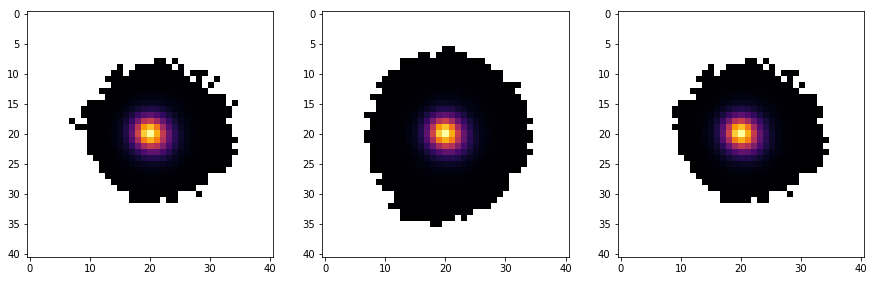

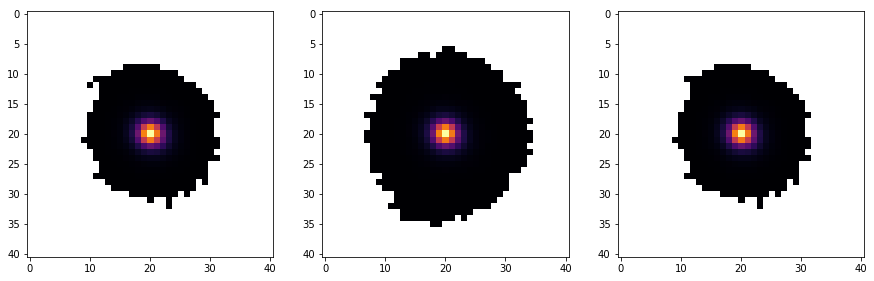

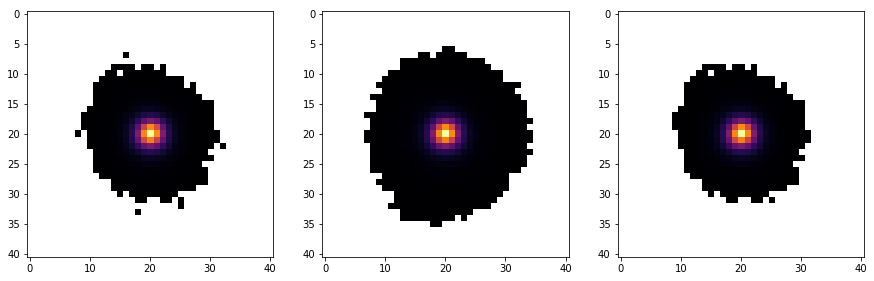

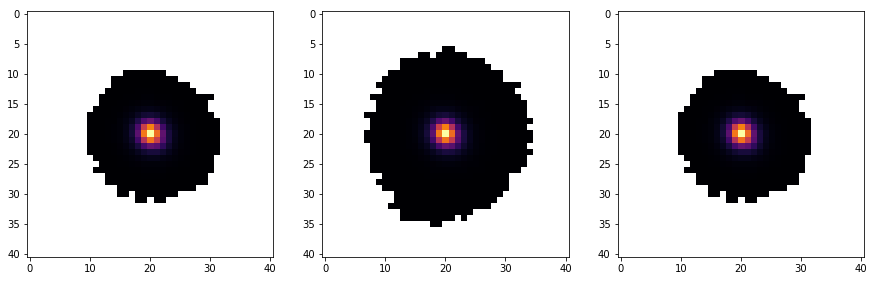

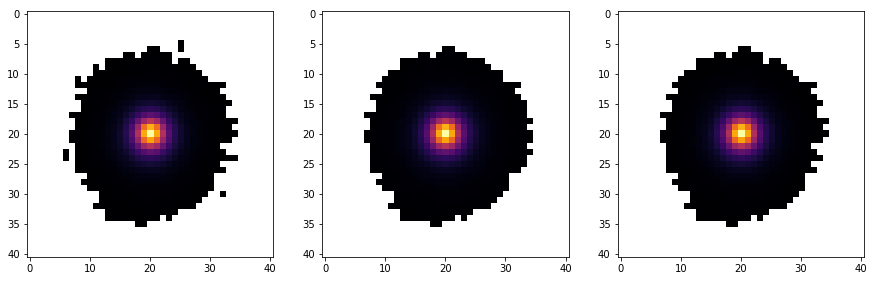

In [13]:
for n,psf in enumerate(psfs):
    fig = plt.figure(figsize=(15,5))
    ax = [fig.add_subplot(1,3,1+n) for n in range(3)]
    masked = np.ma.array(psf, mask=psf<cutoff)
    ax[0].imshow(masked)
    masked = np.ma.array(minimal_psf[n], mask=minimal_psf[n]==0)
    ax[1].imshow(masked)
    masked = np.ma.array(minimal_psf[n], mask=minimal_psf[n]<cutoff)
    ax[2].imshow(masked)
    plt.show()

In [14]:
sources = []
for n,peak in enumerate(peaks):
    try:
        result = scarlet.ExtendedSource((peak[1], peak[0]), images, bg_rms, psf=minimal_psf)
        sources.append(result)
    except:
        print("No flux in peak {0} at {1}".format(n, peak))

blend_psf2 = scarlet.Blend(sources, images, bg_rms=bg_rms)
%time blend_psf2.fit(100, e_rel=.015)
print("scarlet ran for {0} iterations".format(blend_psf2.it))

No flux in peak 7 at [ 52.  36.]


CPU times: user 2.95 s, sys: 13.6 ms, total: 2.96 s
Wall time: 2.95 s
scarlet ran for 100 iterations


Data range: -0.5036830306053162 to 15.331342697143555
residual range: -1.014769654968208 to 2.3758835834233096
rms: 0.10489503483201108


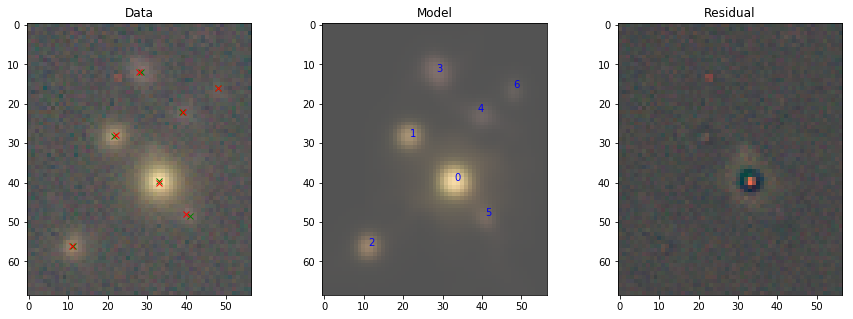

In [15]:
# Load the model and calculate the residual
model = blend_psf2.get_model()
residual = images-model
print("Data range: {0} to {1}\nresidual range: {2} to {3}\nrms: {4}".format(
    np.min(images),
    np.max(images),
    np.min(residual),
    np.max(residual),
    np.sqrt(np.std(residual)**2+np.mean(residual)**2)
))

# Create RGB images
model_rgb = scarlet.display.img_to_rgb(model, filter_indices=filter_indices, norm=norm)
residual_rgb = scarlet.display.img_to_rgb(residual, filter_indices=filter_indices, norm=residual_norm)

# Show the data, model, and residual
fig = plt.figure(figsize=(15,5))
ax = [fig.add_subplot(1,3,n+1) for n in range(3)]
ax[0].imshow(img_rgb)
ax[0].set_title("Data")
ax[1].imshow(model_rgb)
ax[1].set_title("Model")
ax[2].imshow(residual_rgb)
ax[2].set_title("Residual")
for m in range(len(blend.sources)):
    y,x = blend.sources[m].center
    px, py = peaks[m]
    ax[0].plot(x, y, "gx")
    ax[0].plot(px, py, "rx")
    ax[1].text(x, y, m, color="b")
plt.show()

In [16]:
from functools import partial
from scipy.optimize import curve_fit

def gaussian(coords, x0, y0, amplitude, sigma):
    Y,X = coords
    return (amplitude*np.exp(-((X-x0)**2+(Y-y0)**2)/(2*sigma**2))).reshape(-1)

X = np.arange(psfs.shape[2])
Y = np.arange(psfs.shape[1])
X,Y = np.meshgrid(X,Y)
coords = (Y,X)
y0, x0 = psfs.shape[1]//2, psfs.shape[2]//2
amplitude = 1
sigma = 3

amplitudes = np.zeros((len(psfs),))
sigmas = np.zeros((len(psfs),))
for n, psf in enumerate(psfs):
    params, cov = curve_fit(gaussian, coords, psf.reshape(-1), p0=(x0, y0, amplitude, sigma))
    amplitudes[n] = params[2]
    sigmas[n] = params[3]
amplitude = np.mean(amplitudes)
sigma = np.min(sigmas)*.6
target_psf = gaussian(coords, x0, y0, amplitude, sigma).reshape(psfs[0].shape)
#target_psf[target_psf<1e-50] = 0
target_psf = target_psf/np.sum(target_psf)

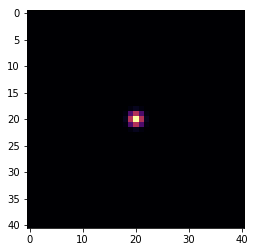

In [17]:
plt.imshow(np.ma.array(target_psf, mask=target_psf==0))

In [18]:
from scarlet.source import Source
from scarlet.config import Config
from scarlet.source import SourceInitError

class PsfModel(Source):
    """Create a model of the PSF in a single band
    """
    def __init__(self, center, psf, cutoff, target_psf, band, constraints=None, monotonic=True,
                 thresh=1., config=None, fix_frame=False, shift_center=0.1):
        self.center = center
        sed, morph = self.make_initial(psf, cutoff, target_psf, band, thresh=thresh,
                                       monotonic=monotonic, config=config)

        if constraints is None:
            constraints = (sc.SimpleConstraint() &
                           sc.DirectMonotonicityConstraint(use_nearest=False))

        super(PsfModel, self).__init__(sed, morph, center=center, constraints=constraints,
                                       fix_sed=True, fix_morph=False, fix_frame=fix_frame,
                                       shift_center=shift_center, psf=target_psf)

    def make_initial(self, psf, cutoff, target_psf, band, thresh=1., monotonic=True, config=None):
        """Initialize the source that is symmetric and monotonic

        Parameters
        ----------
        source: :class:`~scarlet.source.Source`
            `Source` to initialize.
        monotonic: `bool`
            Whether or not to make the initial morphology monotonically decreasing from the peak.
        """
        # Use a default configuration if config is not specified
        if config is None:
            config = Config(source_sizes=np.array([np.max(psf.shape[1:])]))
        # every source as large as the entire image, but shifted to its centroid
        B, Ny, Nx = psf.shape
        self._set_frame(self.center, (Ny,Nx))
        cutoff = np.array(cutoff)

        # determine initial SED from peak position
        sed = np.zeros((B,))
        sed[band] = 1

        # copy morph from detect cutout, make non-negative
        source_slice = self.get_slice_for(psf.shape)
        morph = np.zeros((self.Ny, self.Nx))
        morph[source_slice[1:]] = psf[band, self.bb[1], self.bb[2]].copy()

        # check if source_slice is covering the whole of morph:
        # if not, extend morph by coping last row/column from psf
        if source_slice[1].stop - source_slice[1].start < self.Ny:
            morph[0:source_slice[1].start,:] = morph[source_slice[1].start,:]
            morph[source_slice[1].stop:,:] = morph[source_slice[1].stop-1,:]
        if source_slice[2].stop - source_slice[2].start < self.Nx:
            morph[:,0:source_slice[2].start] = morph[:,source_slice[2].start][:,None]
            morph[:,source_slice[2].stop:] = morph[:,source_slice[2].stop-1][:,None]

        if monotonic:
            # use finite thresh to remove flat bridges
            from . import operators
            prox_monotonic = operators.prox_strict_monotonic((self.Ny, self.Nx), thresh=0.1, use_nearest=False)
            morph = prox_monotonic(morph, 0).reshape(self.Ny, self.Nx)

        # trim morph to pixels above threshold
        # thresh is multiple above the rms of detect (weighted variance across bands)
        _thresh = thresh * cutoff.sum()
        mask = morph > _thresh
        if mask.sum() == 0:
            msg = "No flux above threshold={2} for source at y={0}, x={1}"
            _y, _x = self.center_int
            raise SourceInitError(msg.format(_y, _x, _thresh))
        morph[~mask] = 0

        ypix, xpix = np.where(mask)
        _Ny = np.max(ypix)-np.min(ypix)
        _Nx = np.max(xpix)-np.min(xpix)

        # make sure source has odd pixel numbers and is from config.source_sizes
        _Ny = config.find_next_source_size(_Ny)
        _Nx = config.find_next_source_size(_Nx)

        # need to reshape morph: store old edge coordinates
        old_slice, new_slice = self._set_frame(self.center, (_Ny, _Nx))

        # update morph
        if new_slice != old_slice:
            _morph = np.zeros((self.Ny, self.Nx))
            _morph[new_slice[1],new_slice[2]] = morph[old_slice[1],old_slice[2]]
            morph = _morph

        return sed.reshape((1,B)), morph.reshape((1, morph.shape[0], morph.shape[1]))

In [19]:
import scarlet.constraints as sc

config = scarlet.config.Config(refine_skip=100, source_sizes=np.array([np.max(psfs.shape[1:])]))
center = np.array([psfs[0].shape[0] // 2, psfs[0].shape[1] //2], dtype=psfs.dtype)
print(center)
constraints = sc.SimpleConstraint() & sc.DirectMonotonicityConstraint()# & sc.L0Constraint(1e-6)
cutoffs = [0]*len(psfs)
target_psfs = np.array([target_psf]*len(psfs))
sources = [PsfModel(center, psfs, cutoffs, target_psfs, b, constraints=constraints.copy(), monotonic=False, config=config) for b in range(len(psfs))]
blend = scarlet.Blend(sources, psfs, bg_rms=cutoffs, config=config)
%time blend.fit(30)
print(blend.it)

[ 20.  20.]
CPU times: user 1.15 s, sys: 1.85 ms, total: 1.15 s
Wall time: 1.15 s
18


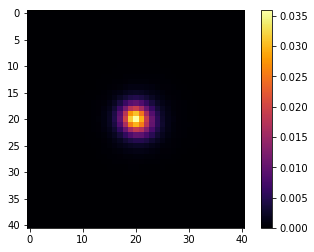

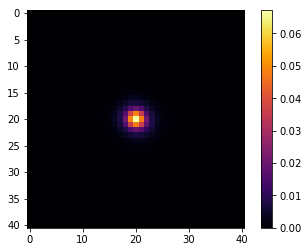

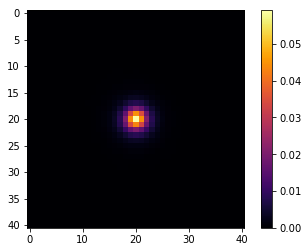

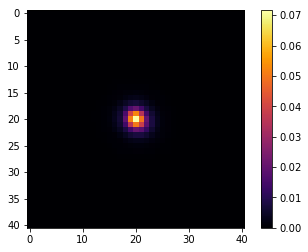

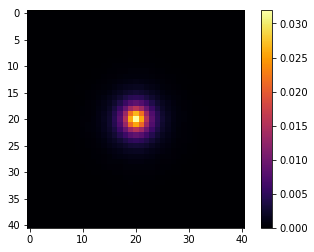

In [20]:
rgb_map = [3,2,1]
for m, src in enumerate(blend.sources):
    model = blend.get_model(m, combine=False, flat=False)
    images = model[rgb_map,:,:].astype(np.float32)
    _model = np.ma.array(model[m], mask=model[m]==0)
    plt.imshow(_model)
    plt.colorbar()
    plt.show()

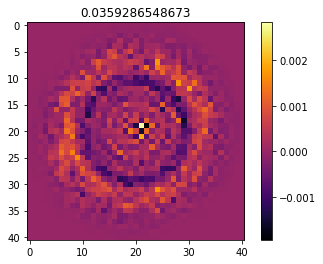

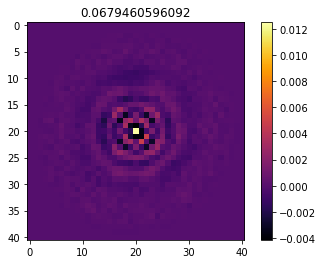

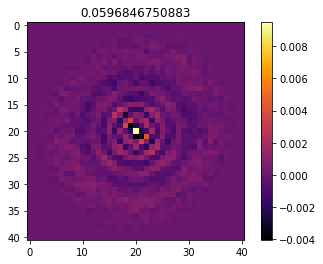

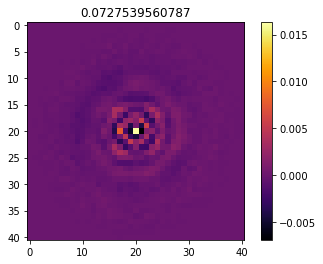

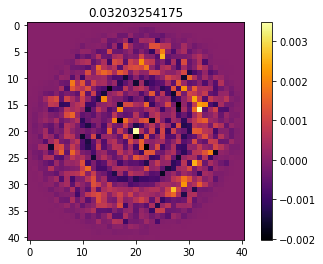

In [21]:
rgb_maps = [[4,3,2],[3,2,1],[2,1,0]]
model = blend.get_model()

"""for rgb_map in rgb_maps:
    colors = rgb.AsinhZScaleMapping(psfs[rgb_map], Q=8)
    images = model[rgb_map,:,:].astype(np.float32)
    rgb_img = colors.makeRgbImage(*images)
    plt.imshow(rgb_img)
    plt.show()"""

for b, psf in enumerate(psfs):
    residual = psf-model[b]
    residual = residual/np.max(psf)
    plt.imshow(residual)
    plt.colorbar()
    plt.title(np.max(psf))
    plt.show()

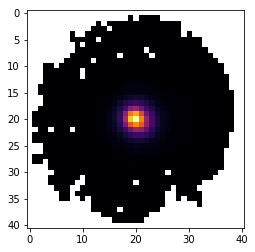

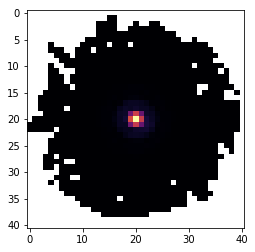

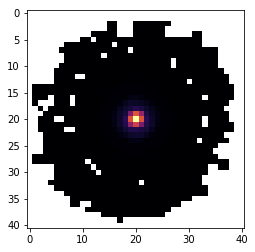

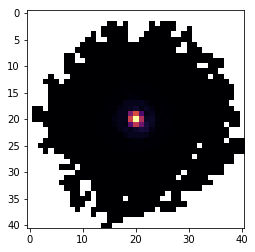

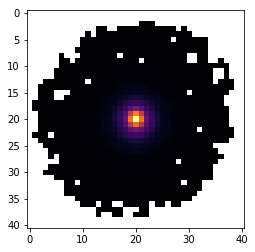

In [23]:
new_psfs = np.array([src.morph for src in blend.sources]).reshape(psfs.shape)
for psf in new_psfs:
    plt.imshow(np.ma.array(psf, mask=psf==0))
    plt.show()

In [25]:
sources = []
images = data["images"]
bg_rms = np.sqrt(np.std(images, axis=(1,2))**2 + np.median(images, axis=(1,2))**2)
print(bg_rms)
for n,peak in enumerate(peaks):
    try:
        result = scarlet.ExtendedSource((peak[1], peak[0]), images, bg_rms, psf=new_psfs)
        sources.append(result)
    except:
        print("No flux in peak {0} at {1}".format(n, peak))

blend_psf3 = scarlet.Blend(sources, images, bg_rms=bg_rms)
%time blend_psf3.fit(100, e_rel=.015)
print("scarlet ran for {0} iterations".format(blend_psf3.it))

[ 0.0493521   0.13865101  0.4235658   0.72557634  0.6836471 ]
No flux in peak 7 at [ 52.  36.]
CPU times: user 2.37 s, sys: 13 ms, total: 2.38 s
Wall time: 2.38 s
scarlet ran for 69 iterations


Data range: -0.5036830306053162 to 15.331342697143555
residual range: -0.7480810480716542 to 0.8756839766756279
rms: 0.09611924868332354


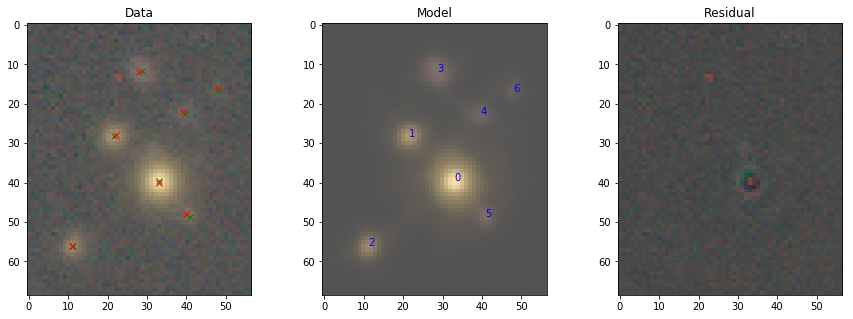

In [26]:
# Load the model and calculate the residual
model = blend_psf3.get_model()
residual = images-model
print("Data range: {0} to {1}\nresidual range: {2} to {3}\nrms: {4}".format(
    np.min(images),
    np.max(images),
    np.min(residual),
    np.max(residual),
    np.sqrt(np.std(residual)**2+np.mean(residual)**2)
))

# Create RGB images
model_rgb = scarlet.display.img_to_rgb(model, filter_indices=filter_indices, norm=norm)
residual_rgb = scarlet.display.img_to_rgb(residual, filter_indices=filter_indices, norm=residual_norm)

# Show the data, model, and residual
fig = plt.figure(figsize=(15,5))
ax = [fig.add_subplot(1,3,n+1) for n in range(3)]
ax[0].imshow(img_rgb)
ax[0].set_title("Data")
ax[1].imshow(model_rgb)
ax[1].set_title("Model")
ax[2].imshow(residual_rgb)
ax[2].set_title("Residual")
for m in range(len(blend_psf3.sources)):
    y,x = blend_psf3.sources[m].center
    px, py = peaks[m]
    ax[0].plot(x, y, "gx")
    ax[0].plot(px, py, "rx")
    ax[1].text(x, y, m, color="b")
plt.show()

In [180]:
%%time
from functools import partial
from scipy.optimize import curve_fit

def moffat(coords, x0, y0, amplitude, alpha, beta=1.5):
    Y,X = coords
    return (amplitude*(1+((X-x0)**2+(Y-y0)**2)/alpha**2)**-beta).reshape(-1)

X = np.arange(psfs.shape[2])
Y = np.arange(psfs.shape[1])
X,Y = np.meshgrid(X,Y)
coords = (Y,X)
y0, x0 = psfs.shape[1]//2, psfs.shape[2]//2
amplitude = 1
alpha = 3
beta = 1.5

amplitudes = np.zeros((len(psfs),))
alphas = np.zeros((len(psfs),))
betas = np.zeros((len(psfs),))
for n, psf in enumerate(psfs):
    params, cov = curve_fit(moffat, coords, psf.reshape(-1), p0=(x0, y0, amplitude, alpha, beta))
    amplitudes[n] = params[2]
    alphas[n] = params[3]
    betas[n] = params[4]
amplitude = np.mean(amplitudes)
alpha = np.min(alpha)*.6
beta = np.max(betas)*1.4
target_psf = moffat(coords, x0, y0, amplitude, alpha, beta).reshape(psfs[0].shape)
target_psf[target_psf<1e-8] = 0
target_psf = target_psf/np.sum(target_psf)

CPU times: user 26.2 ms, sys: 1.02 ms, total: 27.2 ms
Wall time: 26.2 ms


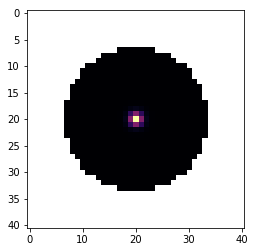

In [181]:
plt.imshow(np.ma.array(target_psf, mask=target_psf==0))

In [182]:
import scarlet.constraints as sc

config = scarlet.config.Config(refine_skip=100, source_sizes=np.array([np.max(psfs.shape[1:])]))
center = np.array([psfs[0].shape[0] // 2, psfs[0].shape[1] //2], dtype=psfs.dtype)
print(center)
constraints = sc.SimpleConstraint() & sc.L0Constraint(1e-4)#& sc.DirectMonotonicityConstraint() & sc.L0Constraint(1e-4)
cutoffs = [0]*len(psfs)
target_psfs = np.array([target_psf]*len(psfs))
sources = [PsfModel(center, psfs, cutoffs, target_psfs, b, constraints=constraints.copy(), monotonic=False, config=config) for b in range(len(psfs))]
blend = scarlet.Blend(sources, psfs, bg_rms=cutoffs, config=config)
%time blend.fit(100, e_rel=1e-3)
print(blend.it)

[ 20.  20.]
CPU times: user 2.32 s, sys: 5.73 ms, total: 2.33 s
Wall time: 2.33 s
71


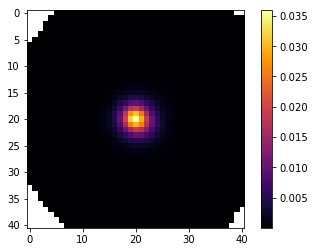

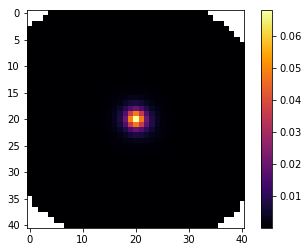

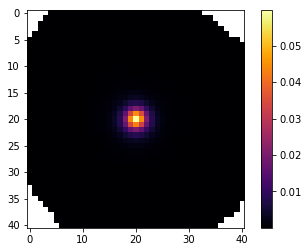

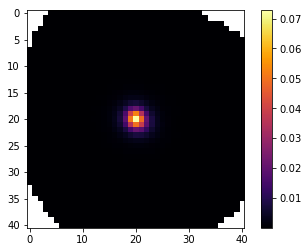

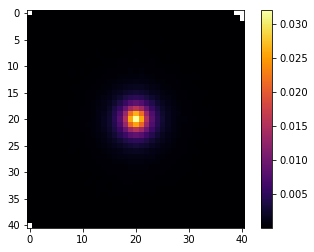

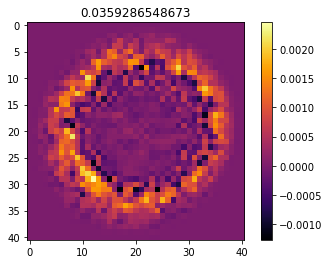

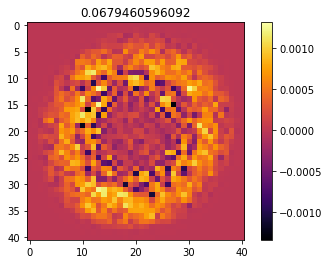

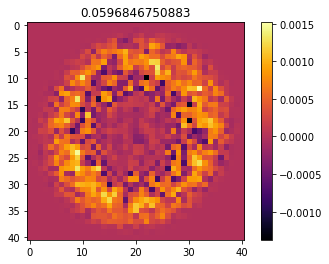

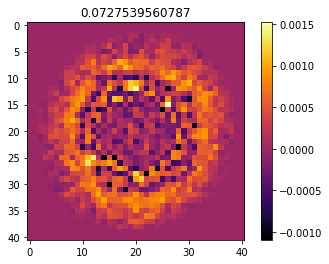

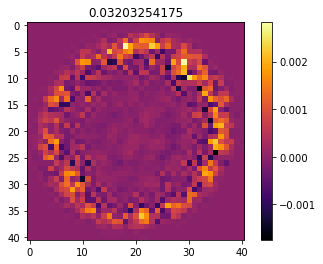

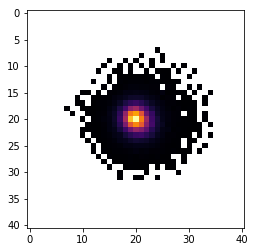

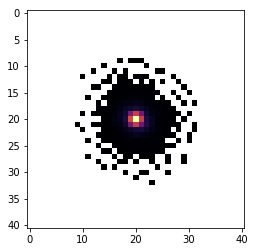

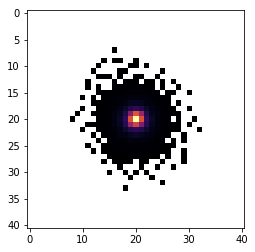

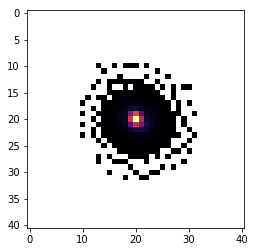

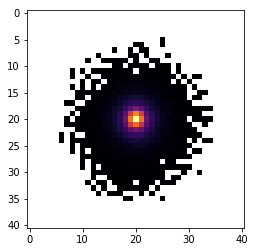

In [183]:
rgb_map = [3,2,1]
for m, src in enumerate(blend.sources):
    model = blend.get_model(m, combine=False, flat=False)
    images = model[rgb_map,:,:].astype(np.float32)
    _model = np.ma.array(model[m], mask=model[m]==0)
    plt.imshow(_model)
    plt.colorbar()
    plt.show()

rgb_maps = [[4,3,2],[3,2,1],[2,1,0]]
model = blend.get_model()
for b, psf in enumerate(psfs):
    residual = psf-model[b]
    residual = residual/np.max(psf)
    plt.imshow(residual)
    plt.colorbar()
    plt.title(np.max(psf))
    plt.show()

new_psfs = np.array([src.morph for src in blend.sources]).reshape(psfs.shape)
for psf in new_psfs:
    plt.imshow(np.ma.array(psf, mask=psf==0))
    plt.show()

In [184]:
sources = []
images = data["images"]
bg_rms = np.sqrt(np.std(images, axis=(1,2))**2 + np.median(images, axis=(1,2))**2)
print(bg_rms)
for n,peak in enumerate(peaks):
    try:
        result = scarlet.ExtendedSource((peak[1], peak[0]), images, bg_rms, psf=new_psfs)
        sources.append(result)
    except:
        print("No flux in peak {0} at {1}".format(n, peak))

blend_psf3 = scarlet.Blend(sources, images, bg_rms=bg_rms)
%time blend_psf3.fit(100, e_rel=.015)
print("scarlet ran for {0} iterations".format(blend_psf3.it))

[ 0.0493521   0.13865101  0.4235658   0.72557634  0.6836471 ]
No flux in peak 7 at [ 52.  36.]
CPU times: user 1.61 s, sys: 14.3 ms, total: 1.62 s
Wall time: 1.62 s
scarlet ran for 76 iterations


Data range: -0.5036830306053162 to 15.331342697143555
residual range: -0.7370848862056629 to 0.8947454798885506
rms: 0.09608026563309185


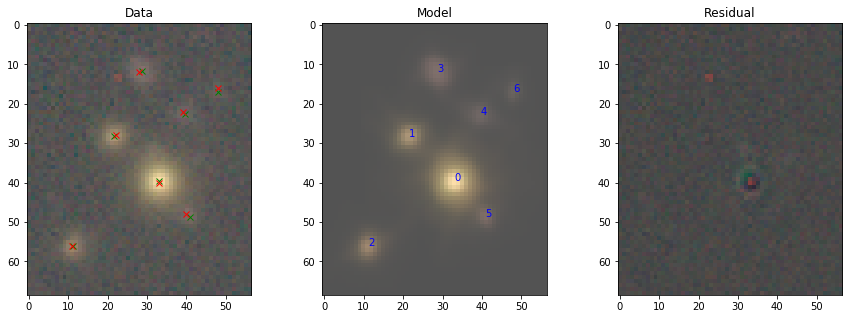

In [185]:
# Load the model and calculate the residual
model = blend_psf3.get_model()
residual = images-model
print("Data range: {0} to {1}\nresidual range: {2} to {3}\nrms: {4}".format(
    np.min(images),
    np.max(images),
    np.min(residual),
    np.max(residual),
    np.sqrt(np.std(residual)**2+np.mean(residual)**2)
))

# Create RGB images
model_rgb = scarlet.display.img_to_rgb(model, filter_indices=filter_indices, norm=norm)
residual_rgb = scarlet.display.img_to_rgb(residual, filter_indices=filter_indices, norm=residual_norm)

# Show the data, model, and residual
fig = plt.figure(figsize=(15,5))
ax = [fig.add_subplot(1,3,n+1) for n in range(3)]
ax[0].imshow(img_rgb)
ax[0].set_title("Data")
ax[1].imshow(model_rgb)
ax[1].set_title("Model")
ax[2].imshow(residual_rgb)
ax[2].set_title("Residual")
for m in range(len(blend_psf3.sources)):
    y,x = blend_psf3.sources[m].center
    px, py = peaks[m]
    ax[0].plot(x, y, "gx")
    ax[0].plot(px, py, "rx")
    ax[1].text(x, y, m, color="b")
plt.show()